In [155]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



import shap

In [156]:
fname = 'data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

%run 'data/utils.py'
%run 'data/features_list.py'
%run 'data/model_params.py'

In [157]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


In [158]:
models = {
    "XG Boost Classifier" : XGBClassifier(objective='reg:squarederror', random_state=24),
    "Random Forest Classifier": RandomForestClassifier(random_state=24),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=24),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=24),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=24),
    # "Bagging Classifier": BaggingClassifier(random_state=24),
    # "Extra Trees Classifier": ExtraTreesClassifier(random_state=24),
    "Logistic Regression": LogisticRegression(random_state=24),
    # "Ridge Classifier": RidgeClassifier(random_state=24),
    # "Perceptron": Perceptron(random_state=24),
    # "SGD Classifier": SGDClassifier(random_state=24),
    # "Gaussian Naive Bayes": GaussianNB(),
    # "Bernoulli Naive Bayes": BernoulliNB(),
    "Support Vector Classifier (SVC)": SVC(random_state=24),
    "Nu-Support Vector Classifier": NuSVC(random_state=24),
    "Linear SVC": LinearSVC(random_state=24)
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    # "Linear Discriminant Analysis": LinearDiscriminantAnalysis(random_state=24),
    # "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(random_state=24)
}

Model: XG Boost Classifier
Accuracy: 64.92%, 90.62%
Precision: 61.89%, 91.06%
Recall: 64.92%, 90.62%
F1 Score: 62.47%, 90.36%
------------------------------
Model: Random Forest Classifier
Accuracy: 69.98%, 100.00%
Precision: 68.10%, 100.00%
Recall: 69.98%, 100.00%
F1 Score: 65.02%, 100.00%
------------------------------
Model: Decision Tree Classifier
Accuracy: 57.98%, 100.00%
Precision: 59.06%, 100.00%
Recall: 57.98%, 100.00%
F1 Score: 58.46%, 100.00%
------------------------------
Model: AdaBoost Classifier
Accuracy: 69.30%, 68.27%
Precision: 67.68%, 69.13%
Recall: 69.30%, 68.27%
F1 Score: 62.55%, 61.42%
------------------------------
Model: Gradient Boosting Classifier
Accuracy: 70.24%, 69.69%
Precision: 68.56%, 69.75%
Recall: 70.24%, 69.69%
F1 Score: 65.32%, 64.88%
------------------------------
Model: Logistic Regression
Accuracy: 69.24%, 68.60%
Precision: 67.40%, 69.28%
Recall: 69.24%, 68.60%
F1 Score: 62.69%, 62.23%
------------------------------
Model: Support Vector Classifie

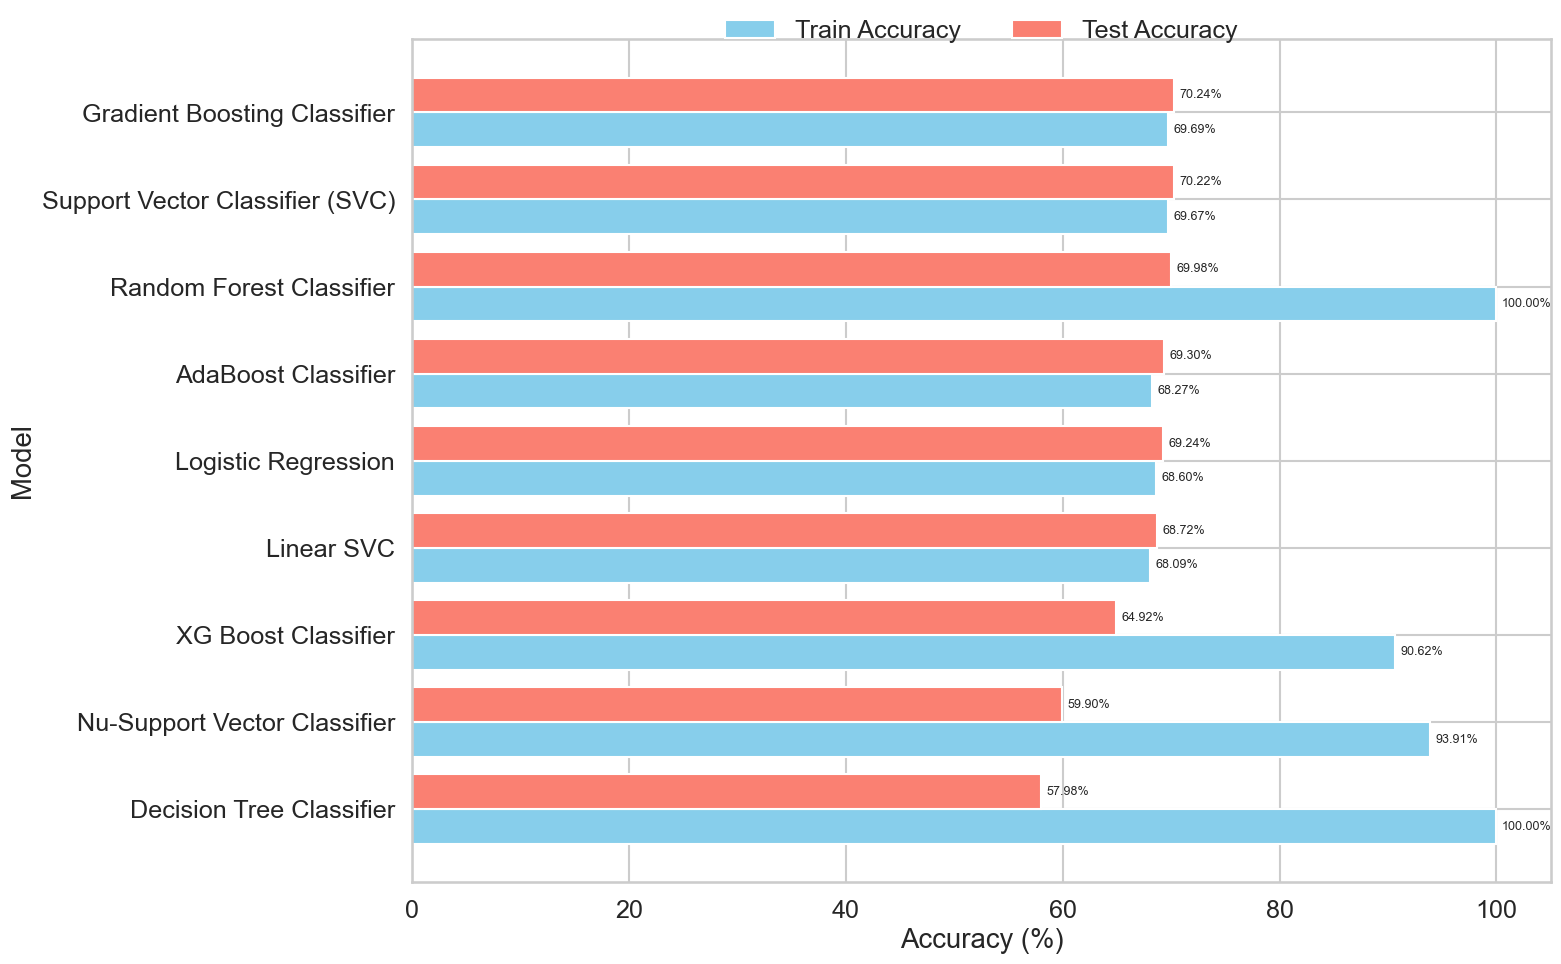

In [159]:
x=df.drop(['dry_eye_disease'],axis=1)
y=df['dry_eye_disease']


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

metrics0 = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = model.predict(x_train)
    acc0 = accuracy_score(y_train, y_pred0)
    f10 = f1_score(y_train, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_train, y_pred0, average='weighted')
    precision0 = precision_score(y_train, y_pred0, average='weighted')

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1 Score'].append(f1 * 100)
    
    metrics0['Model'].append(name)
    metrics0['Accuracy'].append(acc0 * 100)
    metrics0['Precision'].append(precision0 * 100)
    metrics0['Recall'].append(recall0 * 100)
    metrics0['F1 Score'].append(f10 * 100)

    print(f"Model: {name}")
    print(f"Accuracy: {acc * 100:.2f}%, {acc0 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%, {precision0 * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%, {recall0 * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%, {f10 * 100:.2f}%")
    print("-" * 30)
    

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics0 = pd.DataFrame(metrics0)

# Merge train and test metrics for plotting
df_plot = df_metrics.merge(df_metrics0, on="Model", suffixes=("_Test", "_Train"))

# Sort by test accuracy
df_plot = df_plot.sort_values(by="Accuracy_Test", ascending=True).reset_index(drop=True)


# Set up the plot
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Bar positions
y_pos = range(len(df_plot))
bar_width = 0.4

# Plot train accuracy (shifted left)
plt.barh(
    [i - bar_width/2 for i in y_pos],
    df_plot["Accuracy_Train"],
    height=bar_width,
    label="Train Accuracy",
    color="skyblue"
)

# Plot test accuracy (shifted right)
plt.barh(
    [i + bar_width/2 for i in y_pos],
    df_plot["Accuracy_Test"],
    height=bar_width,
    label="Test Accuracy",
    color="salmon"
)

# Y-axis labels
plt.yticks(y_pos, df_plot["Model"])

# Add values to bars
for i, (train_acc, test_acc) in enumerate(zip(df_plot["Accuracy_Train"], df_plot["Accuracy_Test"])):
    plt.text(train_acc + 0.5, i - bar_width/2, f"{train_acc:.2f}%", va="center", fontsize=9)
    plt.text(test_acc + 0.5, i + bar_width/2, f"{test_acc:.2f}%", va="center", fontsize=9)

# Labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
#plt.title("Model Performance: Train vs Test Accuracy", fontsize=14)
plt.xlim(0, 105)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

Model: XG Boost Classifier
Accuracy: 50.30%, 92.17%
Precision: 50.07%, 92.24%
Recall: 50.30%, 92.17%
F1 Score: 50.12%, 92.15%
------------------------------
Model: Random Forest Classifier
Accuracy: 51.24%, 100.00%
Precision: 50.23%, 100.00%
Recall: 51.24%, 100.00%
F1 Score: 49.51%, 100.00%
------------------------------
Model: Decision Tree Classifier
Accuracy: 49.88%, 100.00%
Precision: 49.91%, 100.00%
Recall: 49.88%, 100.00%
F1 Score: 49.89%, 100.00%
------------------------------
Model: AdaBoost Classifier
Accuracy: 52.38%, 53.90%
Precision: 50.04%, 53.89%
Recall: 52.38%, 53.90%
F1 Score: 44.41%, 45.96%
------------------------------
Model: Gradient Boosting Classifier
Accuracy: 51.92%, 59.58%
Precision: 50.33%, 61.27%
Recall: 51.92%, 59.58%
F1 Score: 47.79%, 56.18%
------------------------------
Model: Logistic Regression
Accuracy: 52.60%, 52.87%
Precision: 49.21%, 51.27%
Recall: 52.60%, 52.87%
F1 Score: 41.14%, 41.18%
------------------------------
Model: Support Vector Classifie

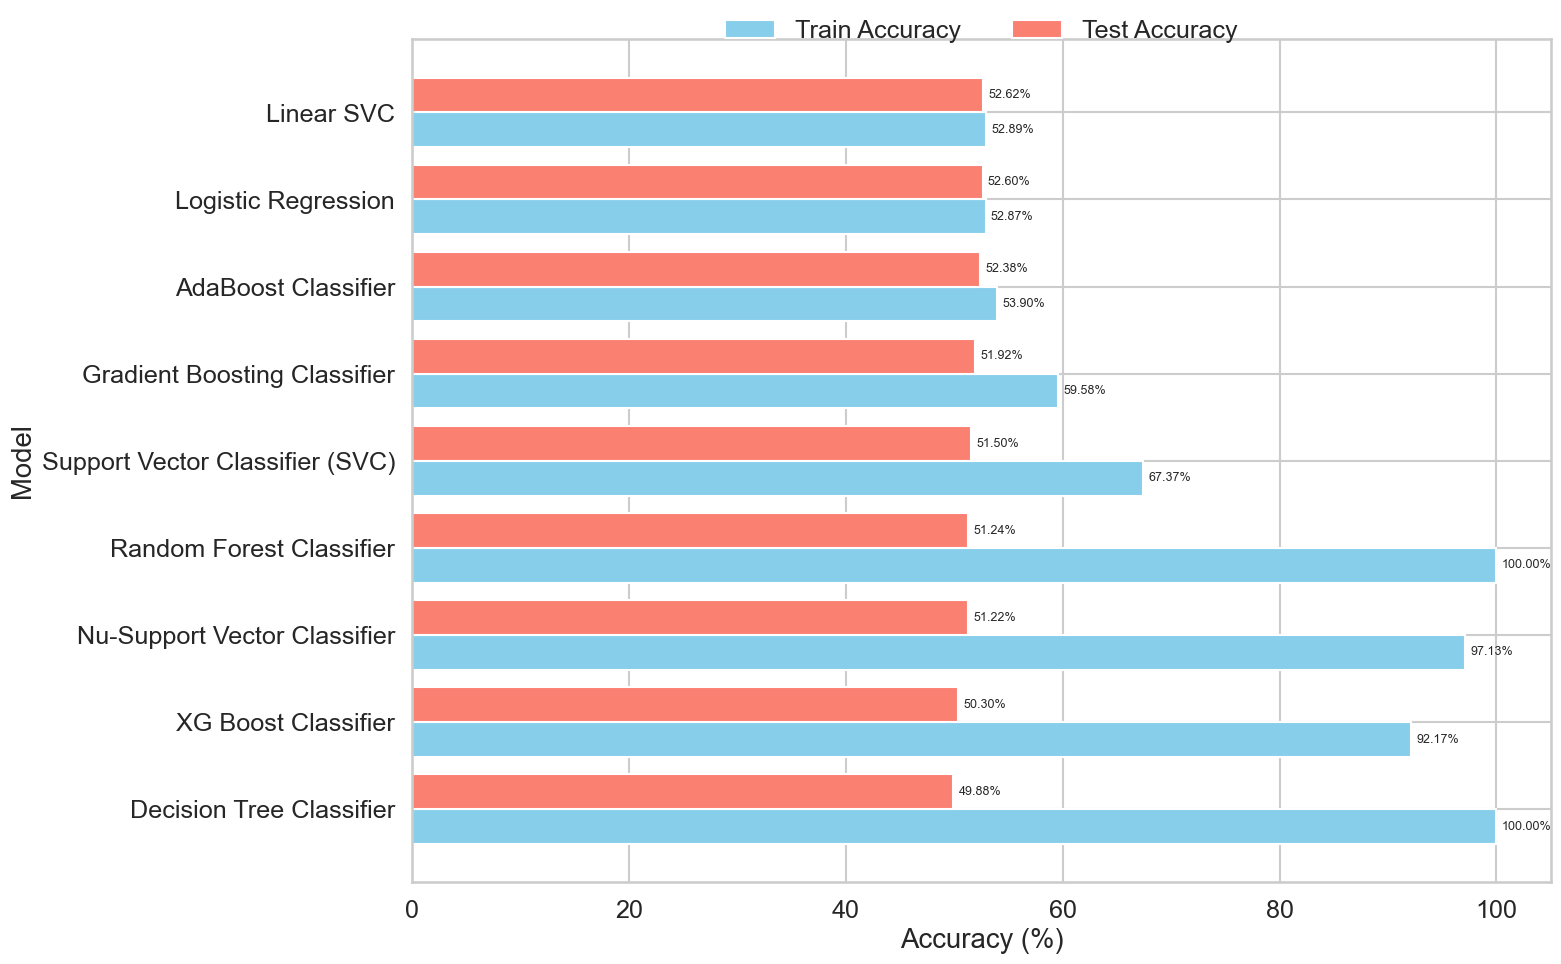

In [160]:
x=df.drop(['insomnia'],axis=1)
y=df['insomnia']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

metrics0 = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = model.predict(x_train)
    acc0 = accuracy_score(y_train, y_pred0)
    f10 = f1_score(y_train, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_train, y_pred0, average='weighted')
    precision0 = precision_score(y_train, y_pred0, average='weighted')

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1 Score'].append(f1 * 100)
    
    metrics0['Model'].append(name)
    metrics0['Accuracy'].append(acc0 * 100)
    metrics0['Precision'].append(precision0 * 100)
    metrics0['Recall'].append(recall0 * 100)
    metrics0['F1 Score'].append(f10 * 100)

    print(f"Model: {name}")
    print(f"Accuracy: {acc * 100:.2f}%, {acc0 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%, {precision0 * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%, {recall0 * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%, {f10 * 100:.2f}%")
    print("-" * 30)
    

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics0 = pd.DataFrame(metrics0)

# Merge train and test metrics for plotting
df_plot = df_metrics.merge(df_metrics0, on="Model", suffixes=("_Test", "_Train"))

# Sort by test accuracy
df_plot = df_plot.sort_values(by="Accuracy_Test", ascending=True).reset_index(drop=True)


# Set up the plot
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Bar positions
y_pos = range(len(df_plot))
bar_width = 0.4

# Plot train accuracy (shifted left)
plt.barh(
    [i - bar_width/2 for i in y_pos],
    df_plot["Accuracy_Train"],
    height=bar_width,
    label="Train Accuracy",
    color="skyblue"
)

# Plot test accuracy (shifted right)
plt.barh(
    [i + bar_width/2 for i in y_pos],
    df_plot["Accuracy_Test"],
    height=bar_width,
    label="Test Accuracy",
    color="salmon"
)

# Y-axis labels
plt.yticks(y_pos, df_plot["Model"])

# Add values to bars
for i, (train_acc, test_acc) in enumerate(zip(df_plot["Accuracy_Train"], df_plot["Accuracy_Test"])):
    plt.text(train_acc + 0.5, i - bar_width/2, f"{train_acc:.2f}%", va="center", fontsize=9)
    plt.text(test_acc + 0.5, i + bar_width/2, f"{test_acc:.2f}%", va="center", fontsize=9)

# Labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
#plt.title("Model Performance: Train vs Test Accuracy", fontsize=14)
plt.xlim(0, 105)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [161]:
df = df0.copy()
df = df[(df['combined_condition']=='both') | (df['combined_condition']=='none')]
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'dry_eye_disease', 'insomnia']
df = df.drop(columns=omit_cols)


['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


Model: XG Boost Classifier
Accuracy: 62.02%, 98.06%
Precision: 60.42%, 98.09%
Recall: 62.02%, 98.06%
F1 Score: 60.36%, 98.06%
------------------------------
Model: Random Forest Classifier
Accuracy: 67.90%, 100.00%
Precision: 69.75%, 100.00%
Recall: 67.90%, 100.00%
F1 Score: 63.21%, 100.00%
------------------------------
Model: Decision Tree Classifier
Accuracy: 56.17%, 100.00%
Precision: 55.97%, 100.00%
Recall: 56.17%, 100.00%
F1 Score: 56.06%, 100.00%
------------------------------
Model: AdaBoost Classifier
Accuracy: 66.57%, 67.59%
Precision: 69.18%, 68.88%
Recall: 66.57%, 67.59%
F1 Score: 60.51%, 61.65%
------------------------------
Model: Gradient Boosting Classifier
Accuracy: 68.27%, 68.45%
Precision: 70.26%, 69.50%
Recall: 68.27%, 68.45%
F1 Score: 63.70%, 63.39%
------------------------------
Model: Logistic Regression
Accuracy: 67.46%, 67.61%
Precision: 69.95%, 68.69%
Recall: 67.46%, 67.61%
F1 Score: 62.10%, 61.82%
------------------------------
Model: Support Vector Classifie

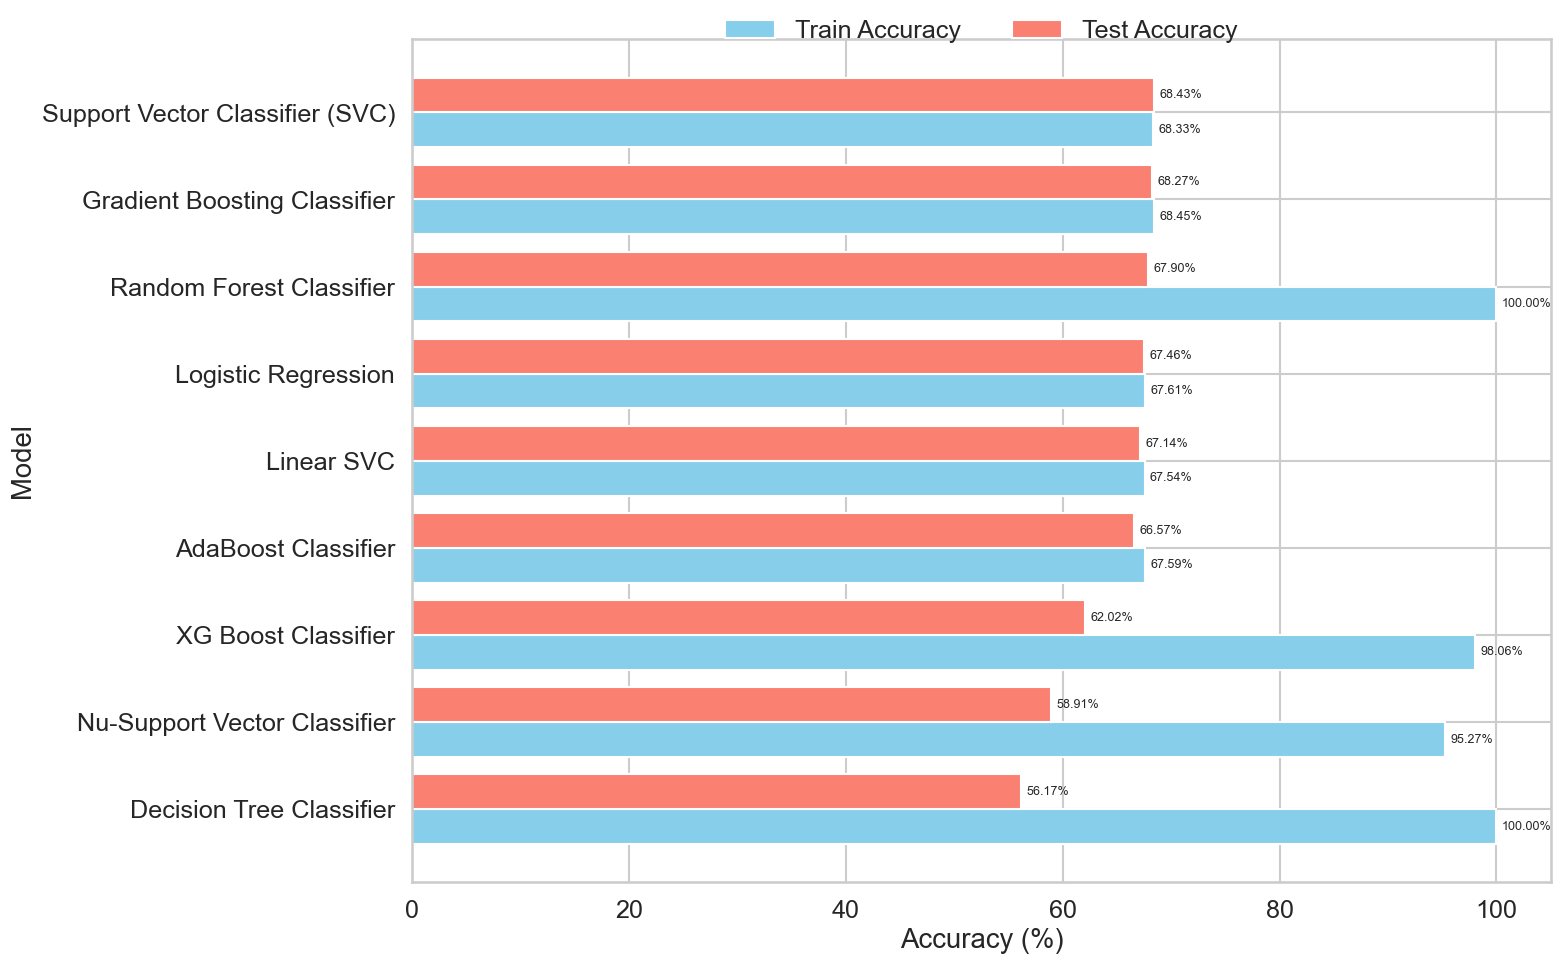

In [162]:
x=df.drop(['combined_condition'],axis=1)
y=df['combined_condition']


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

metrics0 = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = model.predict(x_train)
    acc0 = accuracy_score(y_train, y_pred0)
    f10 = f1_score(y_train, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_train, y_pred0, average='weighted')
    precision0 = precision_score(y_train, y_pred0, average='weighted')

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1 Score'].append(f1 * 100)
    
    metrics0['Model'].append(name)
    metrics0['Accuracy'].append(acc0 * 100)
    metrics0['Precision'].append(precision0 * 100)
    metrics0['Recall'].append(recall0 * 100)
    metrics0['F1 Score'].append(f10 * 100)

    print(f"Model: {name}")
    print(f"Accuracy: {acc * 100:.2f}%, {acc0 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%, {precision0 * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%, {recall0 * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%, {f10 * 100:.2f}%")
    print("-" * 30)
    

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics0 = pd.DataFrame(metrics0)

# Merge train and test metrics for plotting
df_plot = df_metrics.merge(df_metrics0, on="Model", suffixes=("_Test", "_Train"))

# Sort by test accuracy
df_plot = df_plot.sort_values(by="Accuracy_Test", ascending=True).reset_index(drop=True)


# Set up the plot
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Bar positions
y_pos = range(len(df_plot))
bar_width = 0.4

# Plot train accuracy (shifted left)
plt.barh(
    [i - bar_width/2 for i in y_pos],
    df_plot["Accuracy_Train"],
    height=bar_width,
    label="Train Accuracy",
    color="skyblue"
)

# Plot test accuracy (shifted right)
plt.barh(
    [i + bar_width/2 for i in y_pos],
    df_plot["Accuracy_Test"],
    height=bar_width,
    label="Test Accuracy",
    color="salmon"
)

# Y-axis labels
plt.yticks(y_pos, df_plot["Model"])

# Add values to bars
for i, (train_acc, test_acc) in enumerate(zip(df_plot["Accuracy_Train"], df_plot["Accuracy_Test"])):
    plt.text(train_acc + 0.5, i - bar_width/2, f"{train_acc:.2f}%", va="center", fontsize=9)
    plt.text(test_acc + 0.5, i + bar_width/2, f"{test_acc:.2f}%", va="center", fontsize=9)

# Labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
#plt.title("Model Performance: Train vs Test Accuracy", fontsize=14)
plt.xlim(0, 105)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()